<a href="https://colab.research.google.com/github/kartikJ-9/Hair-Strands-Segmentation/blob/master/Hair_strands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
im_width = 128
im_height = 128
border = 5

In [34]:
ids = next(os.walk("/content/drive/My Drive/hair_dataset"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  52


# New Section

In [35]:
#!unzip -uq "/content/drive/My drive/mask_256" -d "/content/drive/My Drive/hair_dataset/mask"


In [36]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [37]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/My Drive/hair_dataset/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = False)
    # Load masks
    mask = img_to_array(load_img("/content/drive/My Drive/hair_dataset/mask/mask_256/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = False)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [38]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Hair Strands')

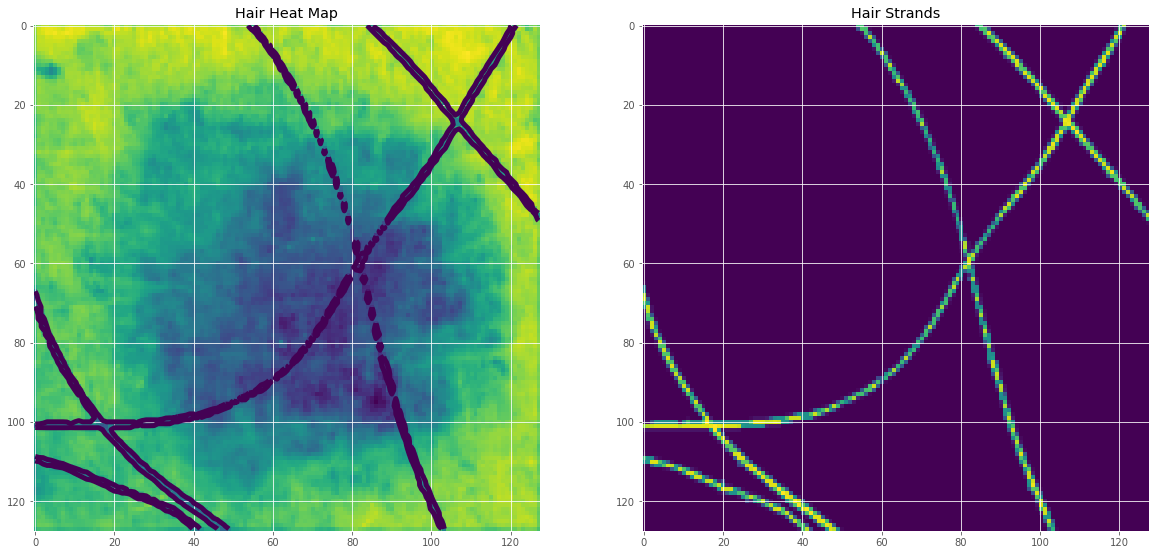

In [39]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0])
if has_mask: 
    ax1.contour(y_train[ix].squeeze(), linewidths = 5, levels = [0.5])
ax1.set_title('Hair Heat Map')

ax2.imshow(y_train[ix].squeeze())
ax2.set_title('Hair Strands')

In [40]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [41]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [42]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________

In [43]:
callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-hair.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [44]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.3784
Epoch 00001: val_loss improved from inf to 0.65305, saving model to model-hair.h5
2/2 [==============================] - 2s 1s/step - loss: 0.7429 - accuracy: 0.3784 - val_loss: 0.6530 - val_accuracy: 0.6196
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.5812
Epoch 00002: val_loss did not improve from 0.65305
2/2 [==============================] - 2s 973ms/step - loss: 0.6682 - accuracy: 0.5812 - val_loss: 0.6544 - val_accuracy: 0.6323
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.6627
Epoch 00003: val_loss did not improve from 0.65305
2/2 [==============================] - 2s 968ms/step - loss: 0.6270 - accuracy: 0.6627 - val_loss: 0.7288 - val_accuracy: 0.4549
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.6982
Epoch 00004: val_loss did not improve from 0.65305
2/2 [========

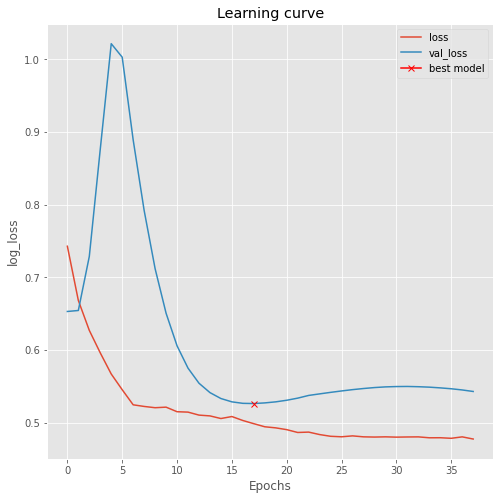

In [45]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [46]:
# load the best model
model.load_weights('model-hair.h5')

In [47]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.8806


[0.526282012462616, 0.880615234375]

In [48]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 2ms/step


In [49]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [50]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), levels=[0.5])
    ax[0].set_title('Skin')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Hair Strands')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), levels=[0.5])
    ax[2].set_title('Hair Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), levels=[0.5])
    ax[3].set_title('Hair Predicted binary');

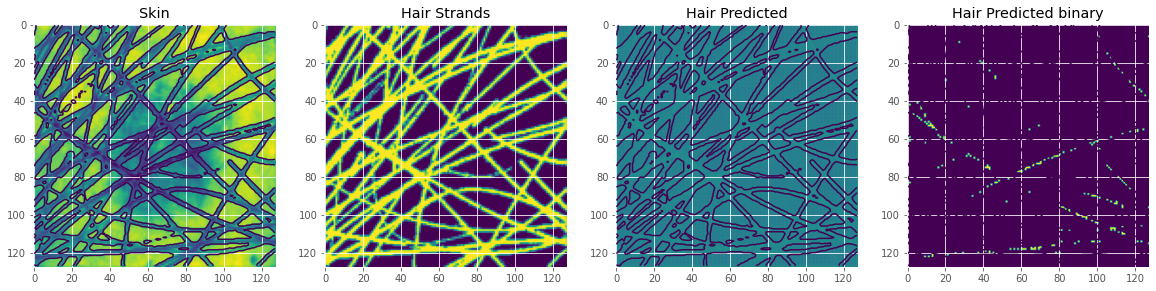

In [51]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

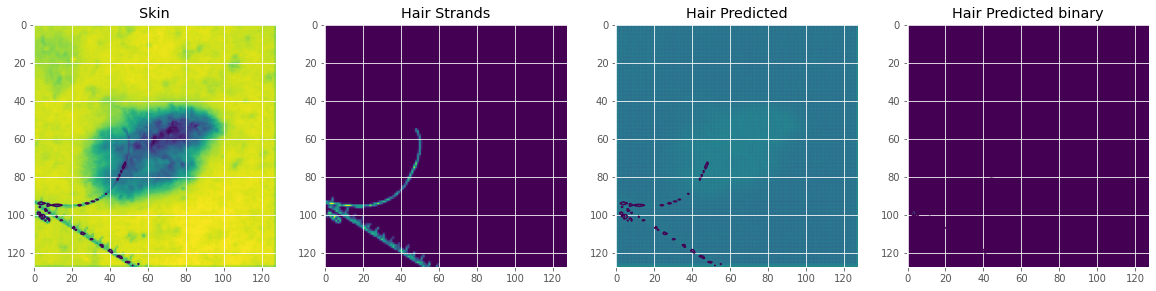

In [52]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

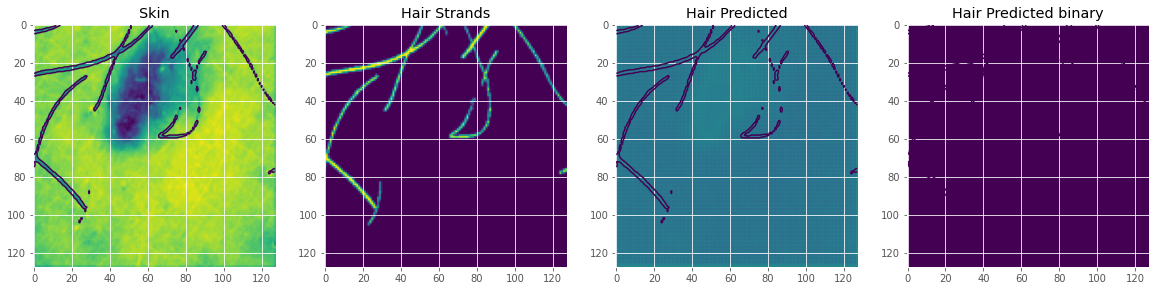

In [53]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

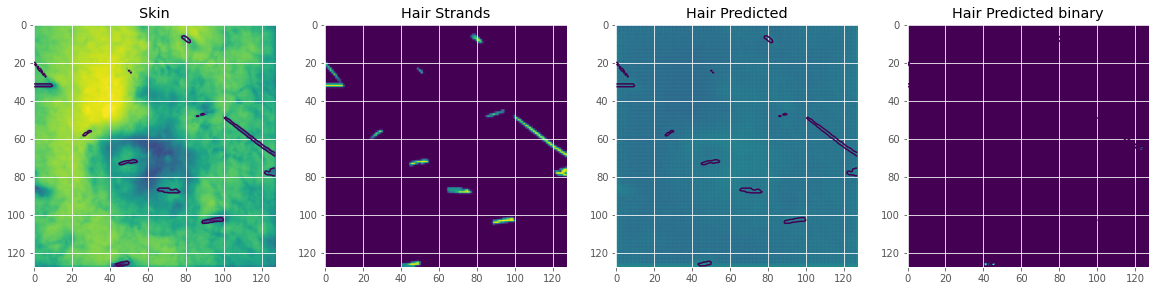

In [54]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

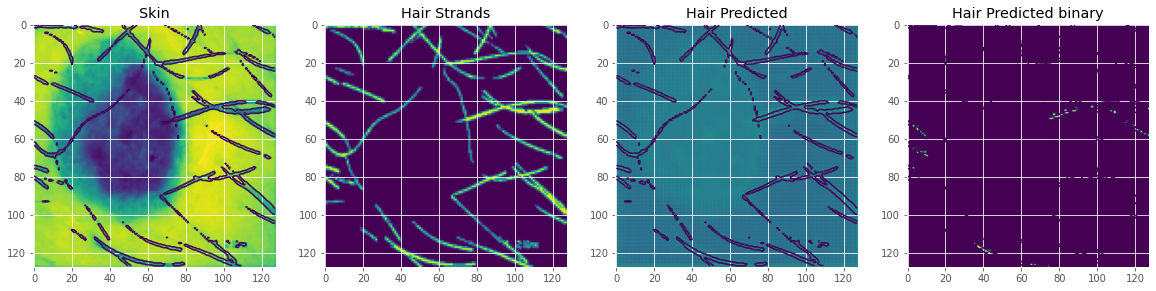

In [55]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

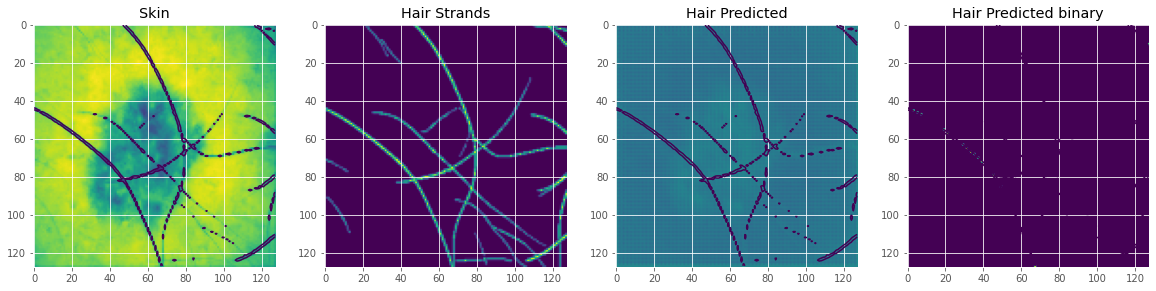

In [56]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

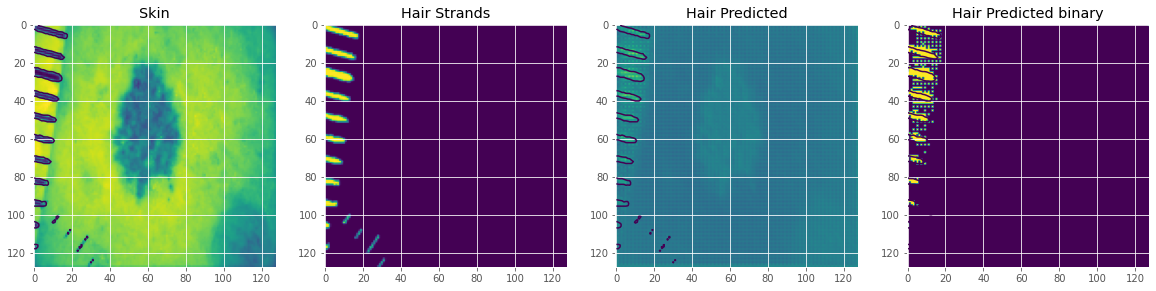

In [57]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

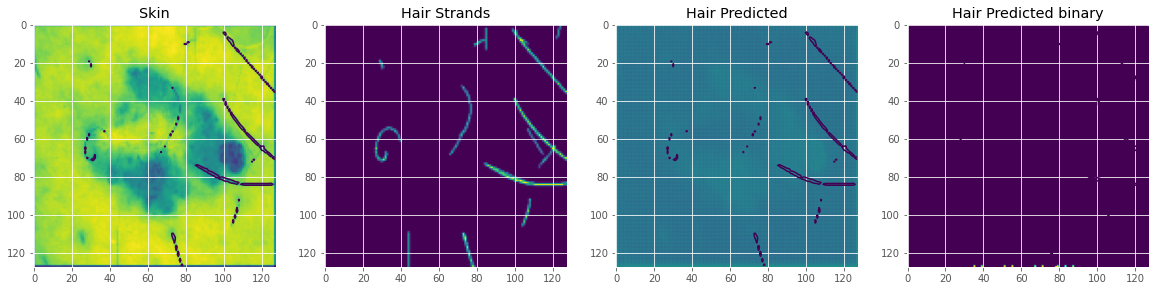

In [58]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

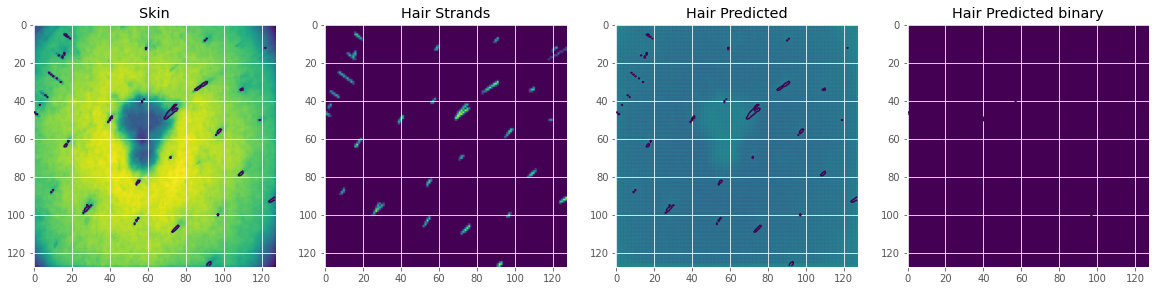

In [59]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

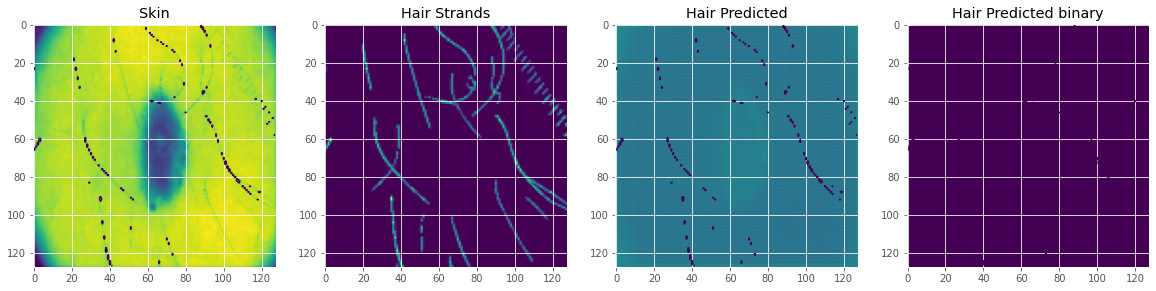

In [60]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

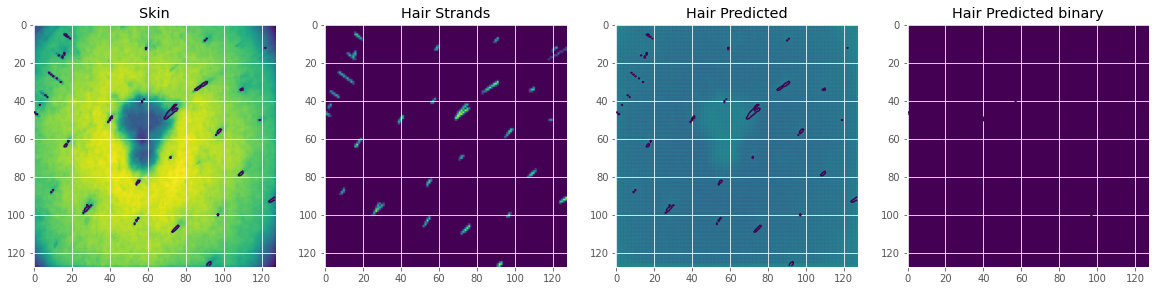

In [61]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

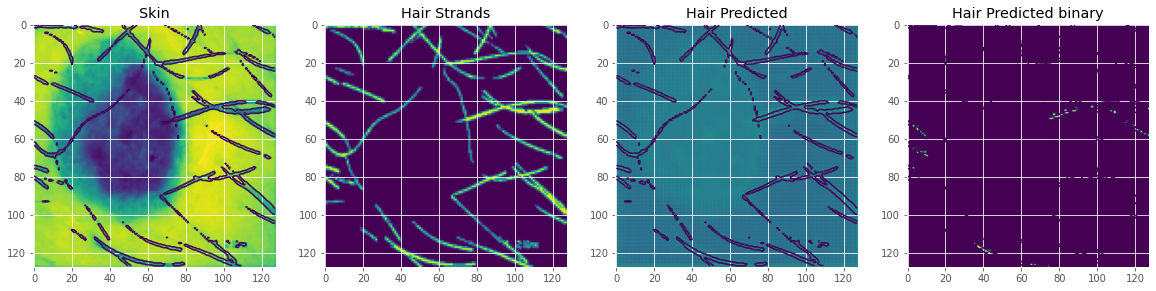

In [62]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

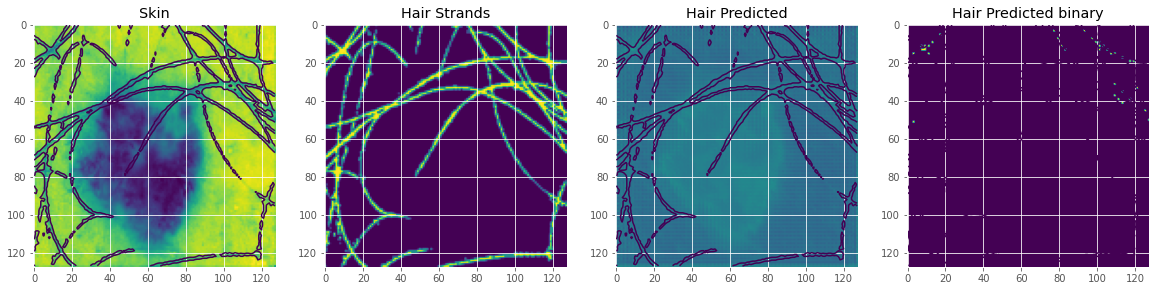

In [63]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=4)

In [64]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

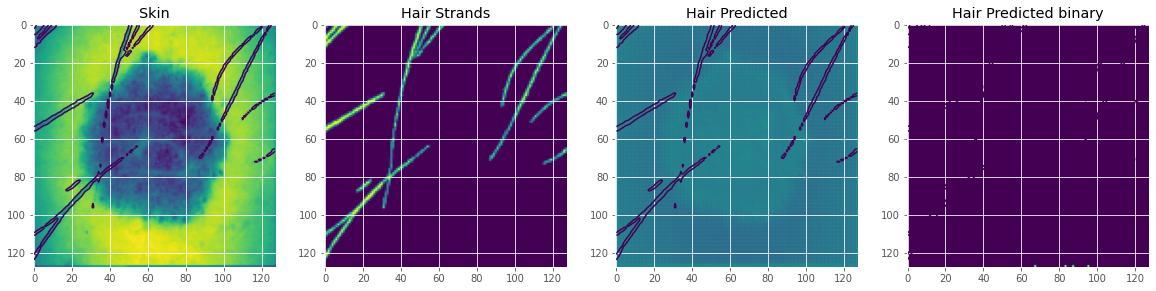

In [65]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

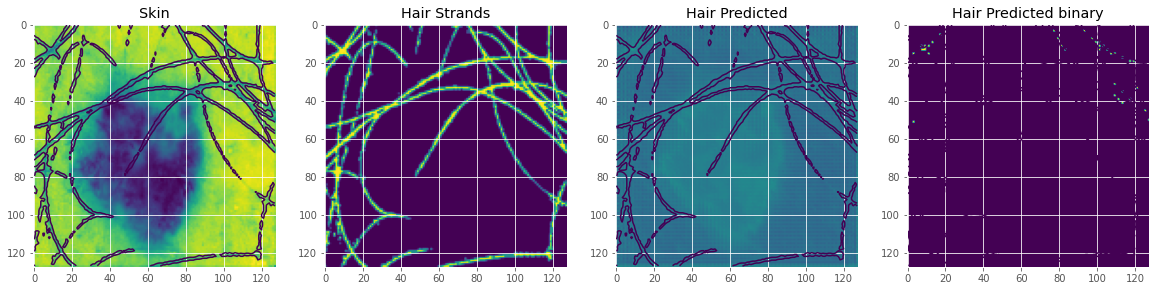

In [66]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

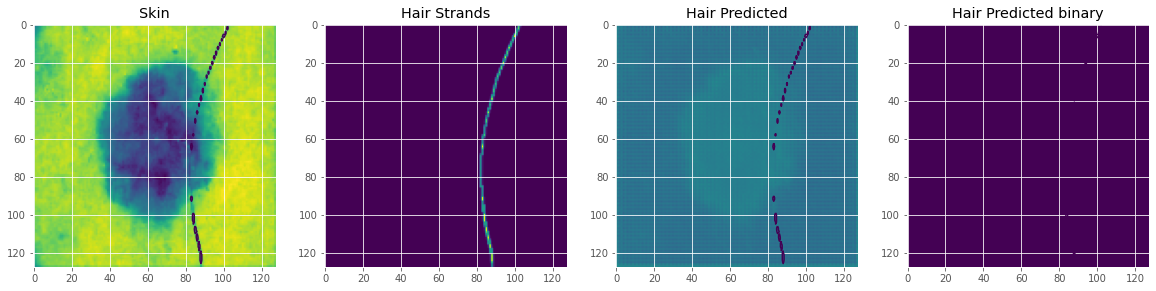

In [67]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

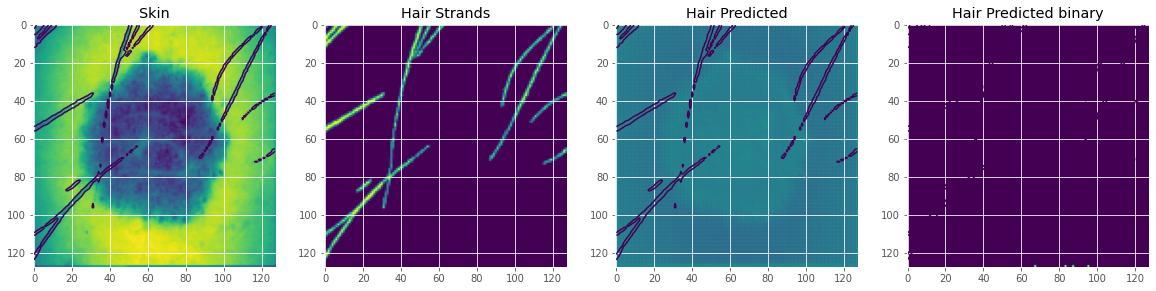

In [69]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)